use python 3.9.13


In [104]:
# pip install -r ../requirements.txt

# Rancangan


---

[ Pilih Soal ]: ⬇️ Stimulus A / Stimulus B

[ Stimulus ]:
Pemanasan global terjadi karena...

[ Pertanyaan ]:
Apa yang menjadi tantangan...

[ Jawaban Siswa ]:
✎ **\*\*\*\***\_**\*\*\*\***--

[🔍 Nilai Jawaban]

📊 Hasil:
✅ Jawaban diklasifikasikan sebagai "Relevan dan Benar" (Label: 1)

🧠 Alasan: Jawaban mengandung kata kunci "pindah", "ekonomi", "sosial"


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [106]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, f1_score
import numpy as np

In [107]:
from sentence_transformers import SentenceTransformer # type: ignore


In [108]:
import optuna
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

---


# Data Understanding


In [109]:
train_a = pd.read_csv('../Dataset/Data_A/data_train_A.csv')
dev_a = pd.read_csv('../Dataset/Data_A/data_dev_A.csv')
test_a = pd.read_csv('../Dataset/Data_A/data_test_A.csv')
train_b = pd.read_csv('../Dataset/Data_B/data_train_B.csv')
dev_b = pd.read_csv('../Dataset/Data_B/data_dev_B.csv')
test_b = pd.read_csv('../Dataset/Data_B/data_test_B.csv')

In [110]:
print("Data Train A:")
print(train_a.head())
print("\nKolom:", train_a.columns.tolist())

Data Train A:
  RES_ID                                           RESPONSE  LABEL
0   TRA1  intetraksi/beradaptasi terhadap lingkungan yan...      1
1   TRA2         seperti jatuhnya meteor tsunami gempa bumi      0
2   TRA3      hanya tuhan yang tahu tantangan nya itu apaan      0
3   TRA4                      mereka akan sulit beradaptasi      1
4   TRA5             Tempat tinggal, ekonomi, dan pekerjaan      1

Kolom: ['RES_ID', 'RESPONSE', 'LABEL']


In [111]:
test_a

,RES_ID,RESPONSE,LABEL
0,TSA1,"beradaptasi dengan lingkunagn baru, lahan dan ...",1
1,TSA2,Pengungsi akan mencari mata pencaharian yang b...,1
2,TSA3,komunitas dan negaranya.,1
3,TSA4,mereka perlu menyesuaikan diri dan beradaptasi...,1
4,TSA5,TANTANGNNYA ADALAH KEBUTUHAN EKONOMI,1
...,...,...,...
850,TSA851,Mereka akan melakukan adaptasi kembali dengan ...,1
851,TSA852,mendapat tempat tinggal baru,0
852,TSA853,KESULITAN AIR BERSIH . MAKANAN DAN SUSAH UNTUK...,1
853,TSA854,perlu waktu untuk beradaptasi di tempat yang baru,1


In [112]:
print("Data Train B:")
print(train_b.head())
print("\nKolom:", train_b.columns.tolist())

Data Train B:
  RES_ID                                           RESPONSE  LABEL
0   TRB1  Karena orang berpikir bahwa jika disumbangkan ...      1
1   TRB2  Pakaian awet adalah alternatif terhadap Fast F...      0
2   TRB3                  karna orang lebih suka menyumbang      1
3   TRB4               karana harga nya terjangkau dan pas.      0
4   TRB5                            kerena harganya mahal .      0

Kolom: ['RES_ID', 'RESPONSE', 'LABEL']


In [113]:
stimulus_a = ["Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi.",
"Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut.",
"kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan.",
"Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan.",
"Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut.",
"Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air.",
"Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut."]

stimulus_b = ["Sebuah toko baju berkonsep self-service menawarkan promosi dua buah baju bertema tahun baru seharga Rp50.000,00. sebelum baju bertema tahun baru dibagikan kepada pembeli, sebuah layar akan menampilkan tampilan gambar yang menampilkan kondisi kerja di dalam sebuah pabrik konveksi/pembuatan baju. ",
"Kemudian pembeli diberi program pilihan untuk menyelesaikan pembeliannya atau menyumpangkan Rp50.000,00 untuk dijadikan donasi pembagian baju musim dingin di suatu daerah yang membutuhkan.",
"Delapan dari sepuluh pembeli memilih untuk memberikan donasi.",
"Menurut anda mengapa banyak dari pembeli yang memilih berdonasi?"]

In [114]:
stimulus_a_text = " ".join(stimulus_a)
stimulus_b_text = " ".join(stimulus_b)

for df in [train_a, dev_a, test_a]:
    df["TEXT"] = stimulus_a_text + " [SEP] " + df["RESPONSE"]

for df in [train_b, dev_b, test_b]:
    df["TEXT"] = stimulus_b_text + " [SEP] " + df["RESPONSE"]


In [115]:
print(train_a.info())
print(train_a.describe(include='all'))  
print(train_b.info())
print(train_b.describe(include='all'))  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RES_ID    268 non-null    object
 1   RESPONSE  268 non-null    object
 2   LABEL     268 non-null    int64 
 3   TEXT      268 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.5+ KB
None
        RES_ID                                           RESPONSE       LABEL  \
count      268                                                268  268.000000   
unique     268                                                265         NaN   
top     TRA268  Pengungsi iklim adalah orang-orang yang terpak...         NaN   
freq         1                                                  3         NaN   
mean       NaN                                                NaN    0.712687   
std        NaN                                                NaN    0.453356   
min        NaN                                

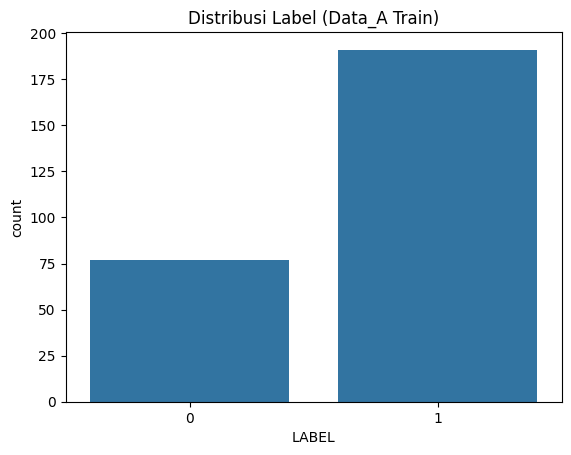

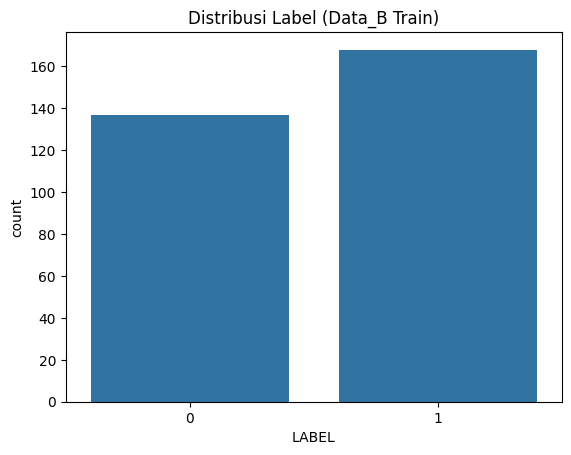

In [116]:
sns.countplot(x='LABEL', data=train_a)
plt.title('Distribusi Label (Data_A Train)')
plt.show()

sns.countplot(x='LABEL', data=train_b)
plt.title('Distribusi Label (Data_B Train)')
plt.show()

---


# Preprocess


In [119]:
stopwords_ukara = {'yang', 'lebih', 'untuk', 'akan', 'mereka', 'dan'}

In [120]:
def preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_ukara]
    return " ".join(tokens)


In [ ]:
train_a["clean_response"] = train_a["RESPONSE"].apply(preprocess)
train_b["clean_response"] = train_b["RESPONSE"].apply(preprocess)
test_a["clean_response"] = test_a["RESPONSE"].apply(preprocess)
test_b["clean_response"] = test_b["RESPONSE"].apply(preprocess)
dev_a["clean_response"] = dev_a["RESPONSE"].apply(preprocess)
dev_b["clean_response"] = dev_b["RESPONSE"].apply(preprocess)


In [123]:
try:
    sbert_model
except NameError:
    sbert_model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1')


In [128]:
def extract_features(df, sbert_model):
    embeddings = sbert_model.encode(df['clean_response'].tolist())
    labels = df['LABEL'].values
    return embeddings, labels


In [ ]:
train_embeddings_a, train_labels_a = extract_features(train_a, sbert_model)
dev_embeddings_a, dev_labels_a = extract_features(dev_a, sbert_model)
test_embeddings_a, test_labels_a = extract_features(test_a, sbert_model)

train_embeddings_b, train_labels_b = extract_features(train_b, sbert_model)
dev_embeddings_b, dev_labels_b = extract_features(dev_b, sbert_model)
test_embeddings_b, test_labels_b = extract_features(test_b, sbert_model)



In [134]:
train_embeddings_a

array([[ 0.00991049,  0.07857347,  0.23972788, ...,  0.05732476,
         0.15967241, -0.00625989],
       [-0.16466887,  0.17444552, -0.04539596, ..., -0.17940426,
         0.16914627,  0.05173503],
       [-0.18770652, -0.06673454, -0.06160488, ..., -0.21614423,
         0.15540378,  0.04898449],
       ...,
       [-0.13524728,  0.37591246,  0.31422368, ...,  0.36557326,
         0.11873639, -0.09988904],
       [-0.00356022,  0.18720648,  0.21095465, ...,  0.03482073,
         0.1142245 ,  0.13776913],
       [-0.05218301, -0.01023853,  0.19516808, ...,  0.10072245,
        -0.09675191,  0.26795632]], dtype=float32)

---


# Model


In [137]:
class AESModel(nn.Module):
    def __init__(self, input_dim):
        super(AESModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [138]:
def train_model_with_params(params, train_embeddings, train_labels):
    if params['use_smote']:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(train_embeddings, train_labels)
    else:
        X_train, y_train = train_embeddings, train_labels
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    
    model = AESModel(input_dim=X_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
    
    current_batch_size = params['batch_size']
    for epoch in range(params['epochs']):
        if params['batch_increase'] > 0 and (epoch+1) % params['increase_freq'] == 0:
            current_batch_size = min(current_batch_size + params['batch_increase'], len(train_dataset))
            
        train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

In [139]:
def objective(trial, train_embeddings, train_labels):
    params = {
        'epochs': trial.suggest_int('epochs', 10, 55),
        'batch_size': trial.suggest_int('batch_size', 2, 8),
        'batch_increase': trial.suggest_int('batch_increase', 0, 4),
        'increase_freq': trial.suggest_int('increase_freq', 2, 4),
        'use_smote': trial.suggest_categorical('use_smote', [True, False])
    }
    
    kf = KFold(n_splits=5)
    scores = []
    
    for train_idx, val_idx in kf.split(train_embeddings):
        X_train, X_val = train_embeddings[train_idx], train_embeddings[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]
        
        model = train_model_with_params(params, X_train, y_train)
        
        val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
        val_loader = DataLoader(val_dataset, batch_size=32)
        
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        scores.append(correct / total)
    
    return np.mean(scores)

In [149]:
def evaluate_model(model, embeddings, labels):
    dataset = TensorDataset(torch.FloatTensor(embeddings), torch.LongTensor(labels))
    loader = DataLoader(dataset, batch_size=32)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    return f1_score(all_labels, all_preds)


---


## Data A


In [142]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_embeddings_a, train_labels_a), n_trials=100)

[I 2025-04-19 16:05:06,985] A new study created in memory with name: no-name-aee4bd9f-6f6d-4ed5-87d0-f997c8931f11
[I 2025-04-19 16:05:11,856] Trial 0 finished with value: 0.8101327742837178 and parameters: {'epochs': 43, 'batch_size': 8, 'batch_increase': 1, 'increase_freq': 3, 'use_smote': False}. Best is trial 0 with value: 0.8101327742837178.
[I 2025-04-19 16:05:18,228] Trial 1 finished with value: 0.8250174703004891 and parameters: {'epochs': 26, 'batch_size': 2, 'batch_increase': 2, 'increase_freq': 4, 'use_smote': False}. Best is trial 1 with value: 0.8250174703004891.
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\bas

In [143]:
best_params = study.best_params
print("Best hyperparameters:", best_params)


Best hyperparameters: {'epochs': 11, 'batch_size': 6, 'batch_increase': 1, 'increase_freq': 4, 'use_smote': False}


In [144]:
final_model = train_model_with_params(best_params, train_embeddings_a, train_labels_a)

In [147]:

dev_f1 = evaluate_model(final_model, dev_embeddings_a, dev_labels_a)
test_f1 = evaluate_model(final_model, test_embeddings_a, test_labels_a)

In [ ]:

print(f"Validation F1-score: {dev_f1:.3f}")
print(f"Test F1-score: {test_f1:.3f}")

Validation F1-score: 0.909
Test F1-score: 0.885


---


## Data B


In [150]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_embeddings_b, train_labels_b), n_trials=100)

[I 2025-04-19 16:13:59,381] A new study created in memory with name: no-name-29ded7c5-e67f-42bf-b597-210969feace9
[I 2025-04-19 16:14:02,879] Trial 0 finished with value: 0.6491803278688525 and parameters: {'epochs': 36, 'batch_size': 4, 'batch_increase': 3, 'increase_freq': 2, 'use_smote': False}. Best is trial 0 with value: 0.6491803278688525.
[I 2025-04-19 16:14:05,054] Trial 1 finished with value: 0.6426229508196721 and parameters: {'epochs': 30, 'batch_size': 6, 'batch_increase': 4, 'increase_freq': 2, 'use_smote': False}. Best is trial 0 with value: 0.6491803278688525.
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\bas

In [151]:
best_params = study.best_params
print("Best hyperparameters:", best_params)


Best hyperparameters: {'epochs': 10, 'batch_size': 4, 'batch_increase': 3, 'increase_freq': 2, 'use_smote': True}


In [152]:
final_model = train_model_with_params(best_params, train_embeddings_b, train_labels_b)

c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [153]:

dev_f1 = evaluate_model(final_model, dev_embeddings_b, dev_labels_b)
test_f1 = evaluate_model(final_model, test_embeddings_b, test_labels_b)

In [154]:

print(f"Validation F1-score: {dev_f1:.3f}")
print(f"Test F1-score: {test_f1:.3f}")

Validation F1-score: 0.656
Test F1-score: 0.665


# Opsi

1. Bert prepocessing + Model
2. Bert Prepocessing, Model Neural
3. Bert ...
